In [1]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt

import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [2]:
logger = logging.getLogger(__name__)
#TODO: build multistage.yaml
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [3]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [4]:

# configure model
base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR,
                    cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)
# if cfg.MODEL.ADAPTATION == "tent":
#     logger.info("test-time adaptation: TENT")
#     model = setup_tent(base_model)
# elif cfg.MODEL.ADAPTATION == "source":
#     logger.info("test-time adaptation: SOURCE")
#     model = setup_source(base_model)

x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
x_test, y_test = x_test.to(device), y_test.to(device)

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



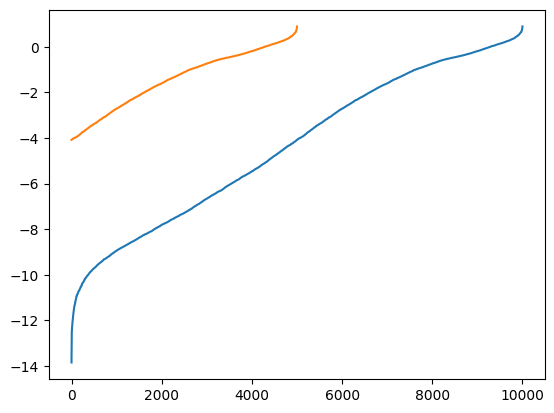

In [5]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())

### Correct samples, Wrong samples entropy histogram visualize

                 0
count  7122.000000
mean     -5.281605
std       3.201368
min     -13.851708
25%      -7.943835
50%      -5.617591
75%      -2.451317
max       0.759301
                 0
count  2878.000000
mean     -2.005370
std       2.446358
min     -12.578241
25%      -3.053679
50%      -1.089867
75%      -0.250885
max       0.892242


(array([  1.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   3.,   1.,   3.,   3.,   2.,   4.,   7.,
          3.,   4.,   3.,   7.,   6.,   5.,   8.,   5.,   5.,   7.,   9.,
          4.,  17.,   9.,   8.,  10.,  11.,  10.,  10.,  10.,  11.,   7.,
         12.,  17.,  15.,   8.,  13.,  14.,  19.,  18.,  15.,  12.,  15.,
         15.,  21.,  19.,  20.,  18.,  22.,  23.,  18.,  28.,  23.,  24.,
         21.,  29.,  34.,  20.,  39.,  28.,  29.,  43.,  41.,  36.,  40.,
         63.,  46.,  55.,  53.,  65.,  52.,  68.,  65.,  76.,  94.,  95.,
        115., 154., 136., 140., 113., 130., 135., 121.,  73.,  49.,  23.,
          8.]),
 array([-12.57824135, -12.44353676, -12.30883121, -12.17412663,
        -12.03942204, -11.90471745, -11.7700119 , -11.63530731,
        -11.50060272, -11.36589813, -11.23119259, -11.096488  ,
        -10.96178341, -10.82707882, -10.69237328, -10.55766869,
        -10.4229641 , -10.28825951, -10.15355396, -10.01884937

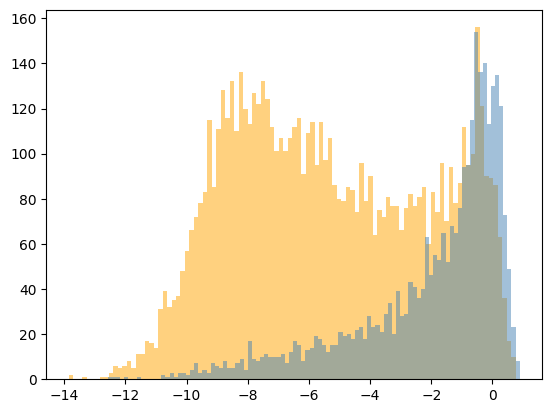

In [6]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [7]:
threshold = -4.0

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

print(f'high entropy accuracy : {correct_high / (correct_high + wrong_high)}') 
print(f'low entropy accuracy : {correct_low / (correct_low + wrong_low)}')

high entropy accuracy : 0    0.523819
dtype: float64
low entropy accuracy : 0    0.895599
dtype: float64


### Dataloader (low_entropy, high_entropy, all)

In [8]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)     

### adaptation with suitable dataset (all)

In [28]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [ ]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)

In [34]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'error : {(1-acc_total):.4f}')  

error : 0.1559


### adaptation with suitable dataset (low)

In [13]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'low_error : {(1-acc_low):.4f}')  

# without updating, check on high entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'high_error : {(1-acc_high):.4f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total):.4f}') 


low_error : 0.0764
high_error : 0.2418
total_error : 0.1591


                 0
count  4618.000000
mean     -5.336160
std       2.229249
min     -11.184581
25%      -6.898446
50%      -5.756617
75%      -4.145475
max       1.097647
                0
count  382.000000
mean    -1.061836
std      1.731994
min     -7.107047
25%     -1.744670
50%     -0.482396
75%      0.138769
max      1.109642


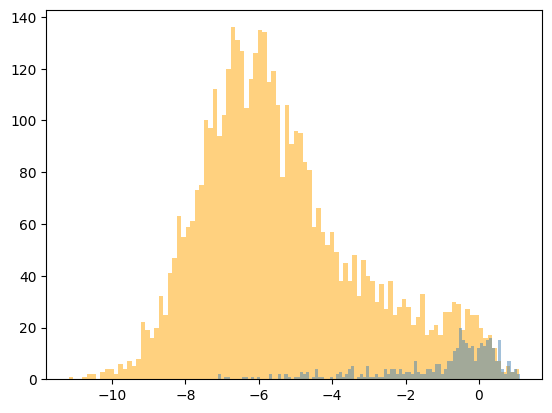

In [29]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3791.000000
mean     -3.519453
std       2.297688
min     -10.565940
25%      -5.216831
50%      -3.509037
75%      -1.538990
max       0.841251
                 0
count  1209.000000
mean     -1.159610
std       1.564542
min      -8.851754
25%      -1.798515
50%      -0.646965
75%      -0.077941
max       1.103291


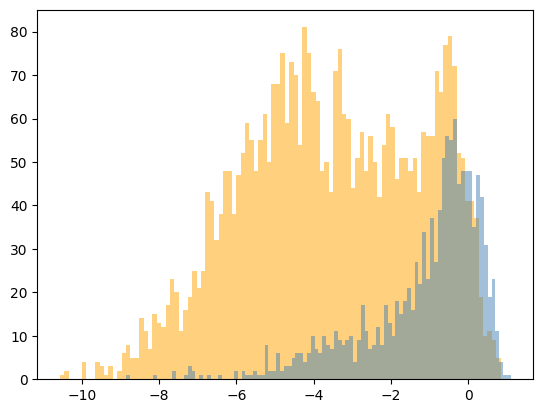

In [30]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

In [31]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'high_error : {(1-acc_high):.4f}')  

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low):.4f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total):.4f}') 

high_error : 0.2548
low_error : 0.0780
total_error : 0.1664


                 0
count  4610.000000
mean     -5.877739
std       2.243865
min     -11.735182
25%      -7.423033
50%      -6.321649
75%      -4.757614
max       0.913978
                0
count  390.000000
mean    -1.279261
std      1.802009
min     -7.803334
25%     -1.980611
50%     -0.642266
75%     -0.062561
max      1.063292


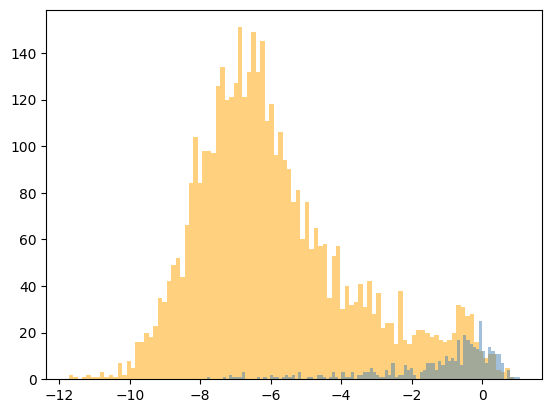

In [32]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3726.000000
mean     -3.223583
std       2.314302
min     -11.859081
25%      -4.926802
50%      -3.143280
75%      -1.192403
max       1.087785
                 0
count  1274.000000
mean     -0.779290
std       1.332838
min      -7.336551
25%      -1.287010
50%      -0.416840
75%       0.117646
max       1.164338


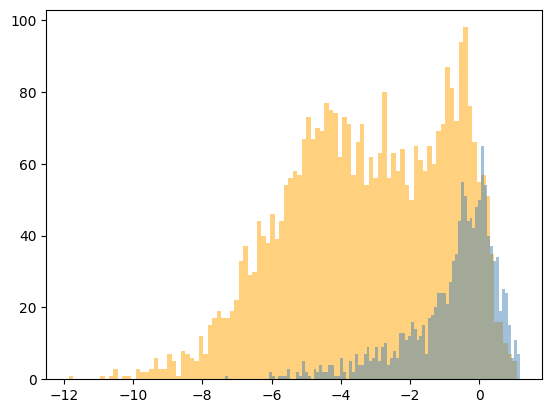

In [33]:
vis_entropy_histogram(outputs_high, y_high)

어째서 이런 결과가?????
- entropy를 minimize하는 것은 현재로서 가장 확률이 높아보이는 class를 pseudo label로 하여 supervision 하는 것과는 차이가 있다
- entropy를 minimize하려면 현재 가장 확률이 높아보이는 class로 가야만 하는 것이 아니고 10가지의 가능성 중 어디로 가도 상관이 없이 목표를 이룰 수 있다
- 이런 자유도가 남아있기 때문에 batch안의 모든 sample들 (low entropy sample 포함) 이 모두 공동의 목표를 이룰 수 있는 방향으로 향하기 때문에 어느정도의 robustness가 확보되는것이 아닐까?

- 그러나 위와 같은 설명으로는 고작 50%정도의 label accuracy를 가지는 high entropy sample들에 대해서만 학습했을 때에도 결과가 16%정도로 꽤 잘나오는 것은 설명할 수 없다.